In [ ]:
import matplotlib as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import os
import pywt
from scipy import signal
import math
from math import *
from PyEMD import EMD
from numpy import *
import sys
import wden

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.decomposition import PCA

import tensorflow

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers.merge import concatenate
from keras.utils import np_utils
from keras.optimizers import SGD, Adam

In [ ]:
def baseline_corr(array):
    # Function for use in baseline removal
    def wrcoef(X, coef_type, coef, wavename, level):
        N = np.array(X).size
        a, ds = coef[0], list(reversed(coef[1:]))

        if coef_type =='a':
            return pywt.upcoef('a', a, wavename, level=level)[:N]
        elif coef_type == 'd':
            return pywt.upcoef('d', ds[level-1], wavename, level=level)[:N]
        else:
            raise ValueError("Invalid coefficient type: {}".format(coef_type))
    #Baseline correction variables
    wavename = 'db1'
    #Baseline correction
    coef = pywt.wavedec(array, wavename, level=10)
    A10 = wrcoef(array, 'a', coef, wavename, 10)
    D10 = wrcoef(array, 'd', coef, wavename, 10)
    D9 = wrcoef(array, 'd', coef, wavename, 9)
    D8 = wrcoef(array, 'd', coef, wavename, 8)
    D7 = wrcoef(array, 'd', coef, wavename, 7)
    D6 = wrcoef(array, 'd', coef, wavename, 6)
    D5 = wrcoef(array, 'd', coef, wavename, 5)
    D4 = wrcoef(array, 'd', coef, wavename, 4)
    D3 = wrcoef(array, 'd', coef, wavename, 3)
    D2 = wrcoef(array, 'd', coef, wavename, 2)
    D1 = wrcoef(array, 'd', coef, wavename, 1)
    array = D10 + D9 + D8 + D7 + D6 + D5 + D4 + D3 + D2 + D1
    return array

In [ ]:
#Extract 1 wave from each signal
def extract_signal (array):
    peak = signal.argrelmax(array, order = 500 )
    start = peak[0][1] - 200
    end = peak[0][1] + 400
    return start, end

In [ ]:
#Read ECG (448 records)
filepath = 'PTB'
completed = 0
total = len(os.listdir(filepath))
signal_array = []
for filename in os.listdir(filepath):
    data = pd.read_csv(filepath + '/' + filename, header = 0, engine = 'python')
    file_array = []
    for column in data:
        if column != 'vx' and column != 'vy' and column != 'vz':
            df = data[column]
            arrays = np.array(df)
            arrays = baseline_corr(arrays)
            start, end = extract_signal(arrays)
            arrays = arrays[start: end]
            arrays = wden.wdenoise(arrays, 'sqtwolog', 'soft', 'mln', 4, 'sym7')
            #arrays = signal.resample(arrays, 800)
            file_array.append(arrays)
    signal_array.append(file_array)
    completed += 1
    progress = completed / total * 100
    progress = round(progress, 2)
    sys.stdout.write('\r'+filename + ' loaded - ' + str(progress) + '% completed')

signal_array = np.asarray(signal_array).reshape(-1, 600, 12)
print('')
print ('Data loading completed ' + str(completed) + ' files loaded')

In [ ]:
#Read labels
data = pd.read_csv("labels.csv", header = 0)
labels = data['diagonsis']
labels = np.asarray(labels)
LABEL = 'Encoded'
le = preprocessing.LabelEncoder()
data[LABEL] = le.fit_transform(data['diagonsis'].values.ravel())
num_classes = le.classes_.size
print(le.classes_)
print('Number of classes: ' + str(num_classes))
print (str(len(labels)) + ' Lables loaded')

In [ ]:
# Create X and Y arrays
X = signal_array
Y = data['Encoded']

# Split the data set in a training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=7)

In [ ]:
# Convert data into data types acceptable by keras
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')

In [ ]:
# One hot encoding
Y_train_hot = np_utils.to_categorical(Y_train, num_classes)

In [ ]:
n_steps = 600
n_features = 1
n_filters = 64
# Seperate input data into 12 section
X1 = X_train[:, :, 0].reshape(X_train.shape[0], X_train.shape[1], n_features)
X2 = X_train[:, :, 1].reshape(X_train.shape[0], X_train.shape[1], n_features)
X3 = X_train[:, :, 2].reshape(X_train.shape[0], X_train.shape[1], n_features)
X4 = X_train[:, :, 3].reshape(X_train.shape[0], X_train.shape[1], n_features)
X5 = X_train[:, :, 4].reshape(X_train.shape[0], X_train.shape[1], n_features)
X6 = X_train[:, :, 5].reshape(X_train.shape[0], X_train.shape[1], n_features)
X7 = X_train[:, :, 6].reshape(X_train.shape[0], X_train.shape[1], n_features)
X8 = X_train[:, :, 7].reshape(X_train.shape[0], X_train.shape[1], n_features)
X9 = X_train[:, :, 8].reshape(X_train.shape[0], X_train.shape[1], n_features)
X10 = X_train[:, :, 9].reshape(X_train.shape[0], X_train.shape[1], n_features)
X11 = X_train[:, :, 10].reshape(X_train.shape[0], X_train.shape[1], n_features)
X12 = X_train[:, :, 11].reshape(X_train.shape[0], X_train.shape[1], n_features)

In [ ]:
# Seperate test data into 12
X_test1 = X_test[:, :, 0].reshape(X_test.shape[0], X_test.shape[1], n_features)
X_test2 = X_test[:, :, 1].reshape(X_test.shape[0], X_test.shape[1], n_features)
X_test3 = X_test[:, :, 2].reshape(X_test.shape[0], X_test.shape[1], n_features)
X_test4 = X_test[:, :, 3].reshape(X_test.shape[0], X_test.shape[1], n_features)
X_test5 = X_test[:, :, 4].reshape(X_test.shape[0], X_test.shape[1], n_features)
X_test6 = X_test[:, :, 5].reshape(X_test.shape[0], X_test.shape[1], n_features)
X_test7 = X_test[:, :, 6].reshape(X_test.shape[0], X_test.shape[1], n_features)
X_test8 = X_test[:, :, 7].reshape(X_test.shape[0], X_test.shape[1], n_features)
X_test9 = X_test[:, :, 8].reshape(X_test.shape[0], X_test.shape[1], n_features)
X_test10 = X_test[:, :, 9].reshape(X_test.shape[0], X_test.shape[1], n_features)
X_test11 = X_test[:, :, 10].reshape(X_test.shape[0], X_test.shape[1], n_features)
X_test12 = X_test[:, :, 11].reshape(X_test.shape[0], X_test.shape[1], n_features)

In [ ]:
# 1st layer
visible1 = Input(shape=(n_steps, n_features))
cnn1 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(visible1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Dropout(0.5)(cnn1)
cnn1 = Flatten()(cnn1)
# 2nd layer
visible2 = Input(shape=(n_steps, n_features))
cnn2 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Dropout(0.5)(cnn2)
cnn2 = Flatten()(cnn2)
# 3rd layer
visible3 = Input(shape=(n_steps, n_features))
cnn3 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(visible3)
cnn3 = MaxPooling1D(pool_size=2)(cnn3)
cnn3 = Dropout(0.5)(cnn3)
cnn3 = Flatten()(cnn3)
# 4th layer
visible4 = Input(shape=(n_steps, n_features))
cnn4 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(visible4)
cnn4 = MaxPooling1D(pool_size=2)(cnn4)
cnn4 = Dropout(0.5)(cnn4)
cnn4 = Flatten()(cnn4)
# 5th layer
visible5 = Input(shape=(n_steps, n_features))
cnn5 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(visible5)
cnn5 = MaxPooling1D(pool_size=2)(cnn5)
cnn5 = Dropout(0.5)(cnn5)
cnn5 = Flatten()(cnn5)
# 6th layer
visible6 = Input(shape=(n_steps, n_features))
cnn6 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(visible6)
cnn6 = MaxPooling1D(pool_size=2)(cnn6)
cnn6 = Dropout(0.5)(cnn6)
cnn6 = Flatten()(cnn6)
# 7th layer
visible7 = Input(shape=(n_steps, n_features))
cnn7 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(visible7)
cnn7 = MaxPooling1D(pool_size=2)(cnn7)
cnn7 = Dropout(0.5)(cnn7)
cnn7 = Flatten()(cnn7)
# 8th layer
visible8 = Input(shape=(n_steps, n_features))
cnn8 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(visible8)
cnn8 = MaxPooling1D(pool_size=2)(cnn8)
cnn8 = Dropout(0.5)(cnn8)
cnn8 = Flatten()(cnn8)
# 9th layer
visible9 = Input(shape=(n_steps, n_features))
cnn9 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(visible9)
cnn9 = MaxPooling1D(pool_size=2)(cnn9)
cnn9 = Dropout(0.5)(cnn9)
cnn9 = Flatten()(cnn9)
# 10th layer
visible10 = Input(shape=(n_steps, n_features))
cnn10 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(visible10)
cnn10 = MaxPooling1D(pool_size=2)(cnn10)
cnn10 = Dropout(0.5)(cnn10)
cnn10 = Flatten()(cnn10)
# 11th layer
visible11 = Input(shape=(n_steps, n_features))
cnn11 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(visible11)
cnn11 = MaxPooling1D(pool_size=2)(cnn11)
cnn11 = Dropout(0.5)(cnn11)
cnn11 = Flatten()(cnn11)
# 12th layer
visible12 = Input(shape=(n_steps, n_features))
cnn12 = Conv1D(filters=n_filters, kernel_size=2, activation='relu')(visible12)
cnn12 = MaxPooling1D(pool_size=2)(cnn12)
cnn12 = Dropout(0.5)(cnn12)
cnn12 = Flatten()(cnn12)

# Combine all layers
merge = concatenate([cnn1,cnn2,cnn3,cnn4,cnn5,cnn6,cnn7,cnn8,cnn9,cnn10,cnn11,cnn12])
dense = Dense(50, activation = 'relu')(merge)
output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=[visible1,visible2,visible3,visible4,visible5,visible6,visible7,visible8,visible9,visible10,visible11,visible12], outputs=output)
print(model.summary())

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='Models/best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_accuracy', save_best_only=True),
    #keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)
]

sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.7, nesterov=False)
adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',
                optimizer=adam, metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 25
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model.fit([X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12],
                          Y_train_hot,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          callbacks=callbacks_list,
                          validation_split=0.2,
                          verbose=2)


135/135 [==============================] - 0s 3ms/step


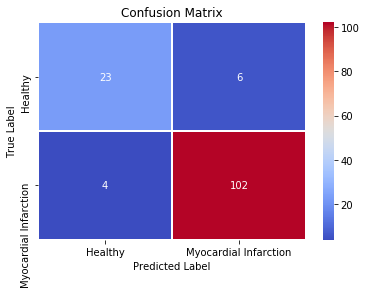

             precision    recall  f1-score   support

          0       0.85      0.79      0.82        29
          1       0.94      0.96      0.95       106

avg / total       0.92      0.93      0.92       135



In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    pyplot.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                annot=True,
                fmt='d')
    pyplot.title('Confusion Matrix')
    pyplot.ylabel('True Label')
    pyplot.xlabel('Predicted Label')
    pyplot.show()

#X_test = X_test.reshape(X_test.shape[0], input_shape)

y_pred_test = model.predict([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6, X_test7, X_test8, X_test9, X_test10, X_test11, X_test12], verbose = 1)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
#max_y_test = np.argmax(Y_test, axis=1)

#X_test = X_test.reshape(X_test.shape[0], input_shape)

show_confusion_matrix(Y_test, max_y_pred_test)

print(classification_report(Y_test, max_y_pred_test))

In [ ]:
#from keras.models import load_model
# Load model
model = load_model('Models/best_model.08-0.17.h5')
print('Model loaded')

In [ ]:
# --92%
# best_model.14-0.19 -- 93%
# best_model.08-0.17 -- 92%
#